In [82]:
import pandas as pd
import numpy as np
import nltk
import spacy
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score as sklearn_f1_score
from transformers import pipeline
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

print("Libraries installed")


Libraries installed


# -------------------------------
# 1. Load Dataset 
# -------------------------------

In [2]:
# Load the job description dataset
data = pd.read_csv("/Users/macadmin/Documents/UoL/Final Project/job_descriptions.csv") 
print("Original Data Preview:")
print(data.head())

# Sampling 500 job descriptions for testing
small_data = data.sample(n=500, random_state=42)

# Saving the sample for testing
small_data.to_csv('small_sample.csv', index=False)

Original Data Preview:
             Job Id     Experience Qualifications Salary Range    location  \
0  1089843540111562  5 to 15 Years         M.Tech    $59K-$99K     Douglas   
1   398454096642776  2 to 12 Years            BCA   $56K-$116K    Ashgabat   
2   481640072963533  0 to 12 Years            PhD   $61K-$104K       Macao   
3   688192671473044  4 to 11 Years            PhD    $65K-$91K  Porto-Novo   
4   117057806156508  1 to 12 Years            MBA    $64K-$87K    Santiago   

            Country  latitude  longitude  Work Type  Company Size  ...  \
0       Isle of Man   54.2361    -4.5481     Intern         26801  ...   
1      Turkmenistan   38.9697    59.5563     Intern        100340  ...   
2  Macao SAR, China   22.1987   113.5439  Temporary         84525  ...   
3             Benin    9.3077     2.3158  Full-Time        129896  ...   
4             Chile  -35.6751   -71.5429     Intern         53944  ...   

                 Contact                     Job Title  \
0   0

# -------------------------------
# 2. Preprocess Dataset
# -------------------------------

In [3]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Text Preprocessing Function
def preprocess(text):    
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

# Preprocess all job descriptions
small_data['processed'] = small_data['Job Description'].apply(preprocess)
print("\nPreprocessed Data Preview:")
print(small_data[['Job Description', 'processed']].head())


Preprocessed Data Preview:
                                           Job Description  \
108318   Promote diversity and inclusion in the supply ...   
7787     Architectural Drafters assist architects and e...   
1237496  An Art Education Coordinator plans and manages...   
55757    Environmental Impact Analysts assess the envir...   
818970   An Art Education Coordinator plans and manages...   

                                                 processed  
108318   promote diversity inclusion supply chain manag...  
7787     architectural drafter assist architect enginee...  
1237496  art education coordinator plan manage art educ...  
55757    environmental impact analyst assess environmen...  
818970   art education coordinator plan manage art educ...  


# --------------------------------------
# 3. Keyword Extraction Using TF-IDF
# --------------------------------------

In [5]:
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=20)  # Extract top 20 keywords

# Fit and transform the preprocessed text
tfidf_matrix = tfidf_vectorizer.fit_transform(small_data['processed'])

# Get the top keywords for each job description
keywords = []
feature_names = tfidf_vectorizer.get_feature_names_out()

for row in tfidf_matrix:
    top_indices = np.argsort(row.toarray()).flatten()[-5:]  # Top 5 keywords
    top_keywords = [feature_names[i] for i in top_indices]
    keywords.append(", ".join(top_keywords))

# Add the keywords as a new column
small_data['TF-IDF Keywords'] = keywords

print(small_data[['Job Description', 'TF-IDF Keywords']].head())

                                           Job Description  \
108318   Promote diversity and inclusion in the supply ...   
7787     Architectural Drafters assist architects and e...   
1237496  An Art Education Coordinator plans and manages...   
55757    Environmental Impact Analysts assess the envir...   
818970   An Art Education Coordinator plans and manages...   

                                 TF-IDF Keywords  
108318         datum, create, user, work, manage  
7787      manage, work, design, create, software  
1237496        datum, create, user, work, manage  
55757    create, manage, provide, datum, analyze  
818970         datum, create, user, work, manage  


# -----------------------------------------------
# 4. Named Entity Recognition (NER) Extraction
# -----------------------------------------------

In [6]:
# Function to extract NER entities (skills, qualifications, job titles)
def extract_ner(text):
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents if ent.label_ in ["ORG", "PERSON", "GPE", "WORK_OF_ART", "PRODUCT"]]
    return ", ".join(entities)

# Apply NER extraction to job descriptions
small_data['NER Keywords'] = small_data['Job Description'].apply(extract_ner)

print(small_data[['Job Description', 'NER Keywords']].head())

                                           Job Description   NER Keywords
108318   Promote diversity and inclusion in the supply ...               
7787     Architectural Drafters assist architects and e...  Drafters, CAD
1237496  An Art Education Coordinator plans and manages...               
55757    Environmental Impact Analysts assess the envir...               
818970   An Art Education Coordinator plans and manages...               


# ------------------------------------------------------------
# 5. Semantic Extraction and Similarity Using BERT 
# ------------------------------------------------------------

In [14]:
# Load BERT pipeline
semantic_extractor = pipeline("feature-extraction", model="bert-base-uncased", device=-1)

# Function to extract BERT-based keywords using noun chunks
def extract_bert_keywords(text, top_n=5):    
    # Extract noun chunks with spaCy
    doc = nlp(text)
    noun_chunks = [chunk.text.lower() for chunk in doc.noun_chunks]
    
    # For simplicity, only return the top N chunks
    return ", ".join(noun_chunks[:top_n])

# Apply BERT-based extraction with spaCy chunks (first 5 rows for runtime efficiency)
small_data['BERT Keywords'] = small_data['Job Description'][:5].apply(extract_bert_keywords)

print("\nSimplified BERT Keywords Preview:")
print(small_data[['Job Description', 'BERT Keywords']].head())


Device set to use cpu



Simplified BERT Keywords Preview:
                                           Job Description  \
108318   Promote diversity and inclusion in the supply ...   
7787     Architectural Drafters assist architects and e...   
1237496  An Art Education Coordinator plans and manages...   
55757    Environmental Impact Analysts assess the envir...   
818970   An Art Education Coordinator plans and manages...   

                                             BERT Keywords  
108318   diversity, inclusion, the supply chain, suppli...  
7787     architectural drafters, architects, engineers,...  
1237496  an art education coordinator, art education pr...  
55757    environmental impact analysts, the environment...  
818970   an art education coordinator, art education pr...  


# ------------------------------------------------
# 6. Search Strategy Query Generation
# ------------------------------------------------

In [15]:
# Combine all keywords into search queries
def generate_search_query(tfidf, ner):
    query_terms = set(tfidf.split(", ") + ner.split(", "))
    return " AND ".join(query_terms)

small_data['Search Strategy'] = small_data.apply(lambda x: generate_search_query(x['TF-IDF Keywords'], x['NER Keywords']), axis=1)
print("\nGenerated Search Strategies:")
print(small_data[['Job Description', 'Search Strategy']].head())


Generated Search Strategies:
                                           Job Description  \
108318   Promote diversity and inclusion in the supply ...   
7787     Architectural Drafters assist architects and e...   
1237496  An Art Education Coordinator plans and manages...   
55757    Environmental Impact Analysts assess the envir...   
818970   An Art Education Coordinator plans and manages...   

                                           Search Strategy  
108318    AND create AND user AND datum AND work AND ma...  
7787     create AND software AND CAD AND Drafters AND w...  
1237496   AND create AND user AND datum AND work AND ma...  
55757     AND create AND datum AND analyze AND manage A...  
818970    AND create AND user AND datum AND work AND ma...  


# ------------------------------------------------
# 6. Save the Results
# ------------------------------------------------

In [16]:
# Save the final DataFrame to a CSV file
small_data.to_csv('processed_job_descriptions.csv', index=False)

print("All steps completed! The results have been saved to 'processed_job_descriptions.csv'.")

All steps completed! The results have been saved to 'processed_job_descriptions.csv'.


# ------------------------------------------------
# 7. Visual Comparison of Results
# ------------------------------------------------

In [18]:
# Side-by-Side Comparison Table
comparison_df = small_data[['Job Description', 'TF-IDF Keywords', 'NER Keywords', 'BERT Keywords', 'Search Strategy']].head()
print("\nComparison of Methods:")
print(comparison_df)


Comparison of Methods:
                                           Job Description  \
108318   Promote diversity and inclusion in the supply ...   
7787     Architectural Drafters assist architects and e...   
1237496  An Art Education Coordinator plans and manages...   
55757    Environmental Impact Analysts assess the envir...   
818970   An Art Education Coordinator plans and manages...   

                                 TF-IDF Keywords   NER Keywords  \
108318         datum, create, user, work, manage                  
7787      manage, work, design, create, software  Drafters, CAD   
1237496        datum, create, user, work, manage                  
55757    create, manage, provide, datum, analyze                  
818970         datum, create, user, work, manage                  

                                             BERT Keywords  \
108318   diversity, inclusion, the supply chain, suppli...   
7787     architectural drafters, architects, engineers,...   
1237496  an ar

# ------------------------------------------------
# 8. Evaluation Metrics 
# ------------------------------------------------

## -----------------------------------------------
## 8.1 Load and Prepare Dataset
## ------------------------------------------------

In [62]:
# Extract only the 'Job Description' and 'skills' columns
data = small_data[['Job Description', 'skills']]

# Display the extracted columns to ensure data is loaded correctly
print("First 5 rows of the dataset:")
print(data.head())

# Save the selected columns to a new CSV file for reference
data.to_csv('job_description_skills.csv', index=False)

First 5 rows of the dataset:
                                           Job Description  \
108318   Promote diversity and inclusion in the supply ...   
7787     Architectural Drafters assist architects and e...   
1237496  An Art Education Coordinator plans and manages...   
55757    Environmental Impact Analysts assess the envir...   
818970   An Art Education Coordinator plans and manages...   

                                                    skills  
108318   Supplier diversity programs Diversity and incl...  
7787     Architectural drafting AutoCAD 2D and 3D model...  
1237496  Art education curriculum Program development T...  
55757    Environmental impact analysis Data collection ...  
818970   Art education curriculum Program development T...  


## ------------------------------------------------
## 8.2 Text Preprocessing using spaCy
## ------------------------------------------------

In [63]:
# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Define preprocessing function
def preprocess(text):  
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

# Apply preprocessing to 'Job Description'
data['processed'] = data['Job Description'].apply(preprocess)

# Display processed text
print("Processed Job Descriptions:")
print(data[['Job Description', 'processed']].head())


Processed Job Descriptions:
                                           Job Description  \
108318   Promote diversity and inclusion in the supply ...   
7787     Architectural Drafters assist architects and e...   
1237496  An Art Education Coordinator plans and manages...   
55757    Environmental Impact Analysts assess the envir...   
818970   An Art Education Coordinator plans and manages...   

                                                 processed  
108318   promote diversity inclusion supply chain manag...  
7787     architectural drafter assist architect enginee...  
1237496  art education coordinator plan manage art educ...  
55757    environmental impact analyst assess environmen...  
818970   art education coordinator plan manage art educ...  


/var/folders/g6/y270stmd4mng02vm3dcdn0880000gn/T/ipykernel_33712/2933099333.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['processed'] = data['Job Description'].apply(preprocess)


## ------------------------------------------------
## 8.3 Generate Ground Truth Keywords
## ------------------------------------------------

In [64]:
# Create Ground Truth Dictionary with Lemmatization and Cleaning
def create_ground_truth(skills_column, nlp):
    ground_truth = {}
    for idx, skills in enumerate(skills_column):
        # Process and clean each skill
        doc = nlp(skills.lower())
        keywords = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
        ground_truth[idx] = keywords
    return ground_truth

# Generate Ground Truth from 'skills' column
ground_truth = create_ground_truth(data['skills'], nlp)

# Display ground truth for verification
print("Ground Truth (first 5 rows):")
for idx in range(5):
    print(f"Row {idx}: {ground_truth[idx]}")


Ground Truth (first 5 rows):
Row 0: ['supplier', 'diversity', 'program', 'diversity', 'inclusion', 'initiative', 'supplier', 'assessment', 'certification', 'datum', 'collection', 'report', 'vendor', 'outreach', 'engagement', 'strategic', 'planning', 'communication', 'skill', 'relationship', 'build', 'attention', 'diversity', 'inclusion', 'principle']
Row 1: ['architectural', 'drafting', 'autocad', '2d', '3d', 'modeling', 'blueprint', 'reading', 'building', 'code', 'collaboration', 'architect', 'detail', 'orient']
Row 2: ['art', 'education', 'curriculum', 'program', 'development', 'teacher', 'train', 'communication', 'skill', 'artistic', 'expertise']
Row 3: ['environmental', 'impact', 'analysis', 'datum', 'collection', 'analysis', 'environmental', 'regulation', 'report', 'gis', 'geographic', 'information', 'system', 'technical', 'writing']
Row 4: ['art', 'education', 'curriculum', 'program', 'development', 'teacher', 'train', 'communication', 'skill', 'artistic', 'expertise']


## ------------------------------------------------
## 8.4 TF-IDF Keyword Extraction
## ------------------------------------------------

In [65]:
# TF-IDF Keyword Extraction
vectorizer = TfidfVectorizer(max_features=5)
tfidf_keywords = []

# Extract top keywords for each processed text
for text in data['processed']:
    tfidf_matrix = vectorizer.fit_transform([text])
    feature_names = [word.lower() for word in vectorizer.get_feature_names_out()]
    tfidf_keywords.append(list(feature_names))

# Display TF-IDF keywords for first 5 rows
print("TF-IDF Keywords (first 5 rows):")
for idx, keywords in enumerate(tfidf_keywords[:5]):
    print(f"Row {idx}: {keywords}")


TF-IDF Keywords (first 5 rows):
Row 0: ['assess', 'chain', 'diversity', 'inclusion', 'supplier']
Row 1: ['accurate', 'architectural', 'drawing', 'software', 'structure']
Row 2: ['appreciation', 'art', 'community', 'coordinator', 'education']
Row 3: ['environmental', 'project', 'promote', 'provide', 'recommendation']
Row 4: ['appreciation', 'art', 'community', 'coordinator', 'education']


## ------------------------------------------------
## 8.5 NER-Based Keyword Extraction
## ------------------------------------------------

In [66]:
# NER-Based Keyword Extraction
def extract_ner_keywords(text):
    doc = nlp(text)
    keywords = [chunk.text.lower() for chunk in doc.noun_chunks]
    return keywords[:5]  # Return top 5 noun chunks

# Apply NER extraction
ner_keywords = data['processed'].apply(extract_ner_keywords)

# Display NER-based keywords
print("NER-Based Keywords (first 5 rows):")
for idx, keywords in enumerate(ner_keywords[:5]):
    print(f"Row {idx}: {keywords}")

NER-Based Keywords (first 5 rows):
Row 0: ['diversity inclusion supply chain', 'supplier diversity program', 'supplier performance']
Row 1: ['architectural drafter', 'architect engineer', 'detailed technical drawing plan building structure', 'computer aid design cad software', 'accurate precise architectural drawing']
Row 2: ['art education coordinator plan', 'art education program curriculum development educational outreach', 'art appreciation', 'community']
Row 3: ['environmental impact analyst', 'environmental consequence project activity conduct study analyze datum', 'recommendation minimize adverse environmental effect', 'sustainable practice']
Row 4: ['art education coordinator plan', 'art education program curriculum development educational outreach', 'art appreciation', 'community']


## ------------------------------------------------
## 8.6 BERT-Based Keyword Extraction
## ------------------------------------------------

In [67]:
# BERT-Based Keyword Extraction using Noun Chunks
def extract_bert_keywords(text, n=5):
    doc = nlp(text)
    keywords = [chunk.text.lower() for chunk in doc.noun_chunks]
    return keywords[:n]

# Apply BERT-based keyword extraction
bert_keywords = data['processed'].apply(lambda x: extract_bert_keywords(x, n=5))

# Display BERT-based keywords for first 5 rows
print("BERT-Based Keywords (first 5 rows):")
for idx, keywords in enumerate(bert_keywords[:5]):
    print(f"Row {idx}: {keywords}")


BERT-Based Keywords (first 5 rows):
Row 0: ['diversity inclusion supply chain', 'supplier diversity program', 'supplier performance']
Row 1: ['architectural drafter', 'architect engineer', 'detailed technical drawing plan building structure', 'computer aid design cad software', 'accurate precise architectural drawing']
Row 2: ['art education coordinator plan', 'art education program curriculum development educational outreach', 'art appreciation', 'community']
Row 3: ['environmental impact analyst', 'environmental consequence project activity conduct study analyze datum', 'recommendation minimize adverse environmental effect', 'sustainable practice']
Row 4: ['art education coordinator plan', 'art education program curriculum development educational outreach', 'art appreciation', 'community']


## ------------------------------------------------
## 8.7 Evaluation Metrics Calculation
## ------------------------------------------------

In [83]:
# Evaluation Metrics Calculation with Cleanup
def calculate_metrics(predicted, ground_truth):
    precision, recall, f1_results = [], [], []
    for i, keywords in enumerate(predicted):
        if i in ground_truth:
            # Clean and align predicted keywords
            predicted_cleaned = [word.strip().lower() for word in keywords]
            ground_truth_cleaned = ground_truth[i]

            # Binary ground-truth match
            y_true = [1 if word in ground_truth_cleaned else 0 for word in predicted_cleaned]
            y_pred = [1] * len(predicted_cleaned)

            if sum(y_true) > 0:  # Handle edge cases where ground truth exists
                precision.append(precision_score(y_true, y_pred))
                recall.append(recall_score(y_true, y_pred))
                f1_results.append(sklearn_f1_score(y_true, y_pred))  # Use sklearn_f1_score
            else:
                precision.append(0)
                recall.append(0)
                f1_results.append(0)
    return np.mean(precision), np.mean(recall), np.mean(f1_results)


## ------------------------------------------------
## 8.8 Evaluate and Compare TF-IDF and BERT
## ------------------------------------------------

In [84]:
# Evaluate TF-IDF Keywords
tfidf_precision, tfidf_recall, tfidf_f1 = calculate_metrics(tfidf_keywords, ground_truth)
print("\nTF-IDF Evaluation:")
print(f"Precision: {tfidf_precision:.2f}, Recall: {tfidf_recall:.2f}, F1-Score: {tfidf_f1:.2f}")

# Evaluate NER Keywords
ner_precision, ner_recall, ner_f1 = calculate_metrics(ner_keywords, ground_truth)
print("\nNER-Based Evaluation:")
print(f"Precision: {ner_precision:.2f}, Recall: {ner_recall:.2f}, F1-Score: {ner_f1:.2f}")

# Evaluate BERT-Based Keywords
bert_precision, bert_recall, bert_f1 = calculate_metrics(bert_keywords, ground_truth)
print("\nBERT-Based Evaluation:")
print(f"Precision: {bert_precision:.2f}, Recall: {bert_recall:.2f}, F1-Score: {bert_f1:.2f}")



TF-IDF Evaluation:
Precision: 0.36, Recall: 0.95, F1-Score: 0.50

NER-Based Evaluation:
Precision: 0.03, Recall: 0.09, F1-Score: 0.04

BERT-Based Evaluation:
Precision: 0.03, Recall: 0.09, F1-Score: 0.04


## ------------------------------------------------
## 8.9 Visual Comparison
## ------------------------------------------------

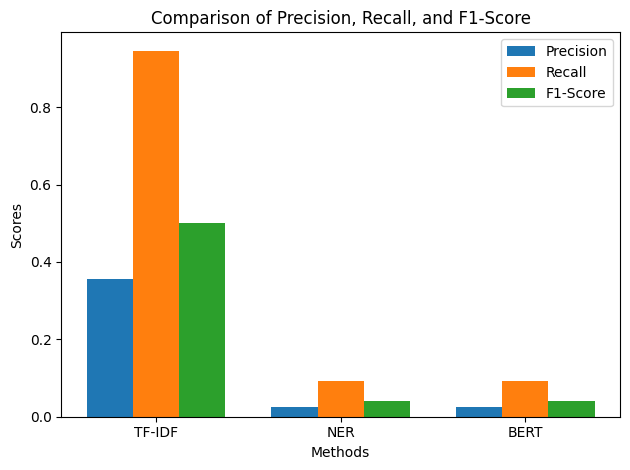

In [85]:
# Results for visualization
methods = ['TF-IDF', 'NER', 'BERT']
precision = [tfidf_precision, ner_precision, bert_precision]
recall = [tfidf_recall, ner_recall, bert_recall]
f1_results = [tfidf_f1, ner_f1, bert_f1]  # Renamed from f1_score

# Plotting
fig, ax = plt.subplots()
bar_width = 0.25
index = np.arange(len(methods))

# Bars for each metric
plt.bar(index, precision, bar_width, label='Precision')
plt.bar(index + bar_width, recall, bar_width, label='Recall')
plt.bar(index + 2 * bar_width, f1_results, bar_width, label='F1-Score')  # Use renamed variable

# Formatting
plt.xlabel('Methods')
plt.ylabel('Scores')
plt.title('Comparison of Precision, Recall, and F1-Score')
plt.xticks(index + bar_width, methods)
plt.legend()

plt.tight_layout()
plt.show()
